<a href="https://colab.research.google.com/github/PLASTA0728/fft-extract-music-notes/blob/main/Fourier-Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile # get the api
import os

import numpy as np
import pandas as pd
import tqdm


## Core code defining the FourierExtractor class

In [58]:
class FourierExtractor:

  def __init__(self,
               fps = 30,
               fft_window_seconds = 0.25,
               freq_min = 10,
               freq_max = 1000,
               top_notes = 3,):
    self.fps = fps
    self.fft_window_seconds = fft_window_seconds
    self.freq_min, self.freq_max = freq_min, freq_max
    self.top_notes = top_notes

    self.note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

  def transform_wavfile(self, fs, audio):
    """
      Arguments: fs: int, sample rate of audio file
                 audio: np.array[np.float32], array defining an audio signal

      Returns:   List[np.array[np.float32]], list of arrays defining fast
                  fourier transforms at defined window sizes across the
                  audio sample
    """
    frame_step = (fs / self.fps) # audio samples per video frame
    fft_window_size = int(fs * self.fft_window_seconds)
    audio_length = len(audio)/fs

    frame_count = int(audio_length*self.fps)
    frame_offset = int(len(audio)/frame_count)

    # Original source refers to this as a "Hanning" window, which appears to
    #  be a portmanteau of "Hann" and "Hamming".
    # As I understand it, this will scale the frequencies of each window as
    # the FFT algorithm passes over it, reducing the amplitudes of the wave
    # at the start and end of the window
    window = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, fft_window_size, False)))

    transforms = []
    for frame_number in range(frame_count):
      # Extract audio window from file
      end_frame = frame_number * frame_offset
      start_frame = int(end_frame - fft_window_size)
      sample = self.extract_sample(audio, start_frame, end_frame)

      fft = np.fft.rfft(sample * window)
      fft = np.abs(fft).real

      # Avoid divide-by-zero by specifying a very small minimum divisor
      fft_norm = fft / max(1e-20, np.max(fft))

      # Truncate the fft to within prefined min and max frequencies
      fft_norm = fft_norm[self.freq_min:self.freq_max]

      transforms.append(fft_norm)

    return np.array(transforms)

  def extract_sample(self, audio, start: int, end: int):
    """
      Given an audio array and a start and end frame, returns the slice of the
       list defined by the start and end frames
      Pads with zeroes when appropriate.
    """
    if end == 0:
      # We have no audio yet, return all zeros (very beginning)
      return np.zeros((np.abs(start)),dtype=float)
    elif start < 0:
      # We have some audio, pad with zeros
      return np.concatenate([np.zeros((np.abs(start)),dtype=float),audio[0:end]])
    else:
      # Usually this happens, return the next sample
      return audio[start:end]


  def note_name(self, n):
    n = round(n)
    return self.note_names[n % 12] + str(int(n/12 - 1))

  # Static methods for number manipulation These do not accept the parent object
  #  as the first argument (i.e. no "self" argument)
  @staticmethod
  def freq_to_number(freq):
    return 69 + 12*np.log2(freq/440.0)

  @staticmethod
  def number_to_freq(n):
    return 440 * 2.0**((n-69)/12.0)






## Load Audio File

We use the wavefile method from scipy to read in the audio.

wavfile() returns the sample rate of the audio, and an array of amplitudes for each track in the audio file


In [6]:
!wget https://github.com/jeffheaton/present/raw/master/youtube/video/sample_audio/piano_c_major_scale.wav
AUDIO_FILE = "/content/piano_c_major_scale.wav"

PATH = '/content/drive/MyDrive/projects/audio'
fs, data = wavfile.read(os.path.join(PATH,AUDIO_FILE)) # load the data
audio = data.T[0] # this is a two channel soundtrack, get the first track

--2024-09-08 11:46:15--  https://github.com/jeffheaton/present/raw/master/youtube/video/sample_audio/piano_c_major_scale.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jeffheaton/present/master/youtube/video/sample_audio/piano_c_major_scale.wav [following]
--2024-09-08 11:46:18--  https://raw.githubusercontent.com/jeffheaton/present/master/youtube/video/sample_audio/piano_c_major_scale.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4921652 (4.7M) [audio/wav]
Saving to: ‘piano_c_major_scale.wav.1’

piano_c_major_scale 100%[===================>]   4.69M  --.-KB/s    in 0.06s   

2024-09-

<ipython-input-6-360ca2a60b70>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read(os.path.join(PATH,AUDIO_FILE)) # load the data


We now instantiate the extractor defined above.

We then call transform_wavfile on the extractor, passing in the frame rate and audio array. This gets us an array of fourier transformed windows of the audio.

With current settings, this results in 418 samples from the audio, each of length 5513.

In [59]:
extractor = FourierExtractor()
transforms = extractor.transform_wavfile(fs, audio)

print(transforms.shape)

(418, 990)


We can visualise each of the 418 samples by passing them into a pandas DataFrame and calling plot() e.g.

```pd.DataFrame(transforms[100]).plot()```

<Axes: >

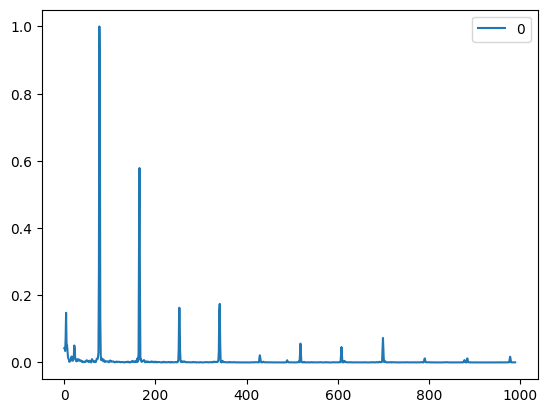

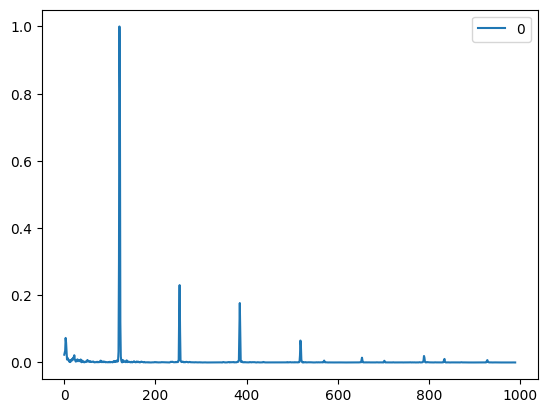

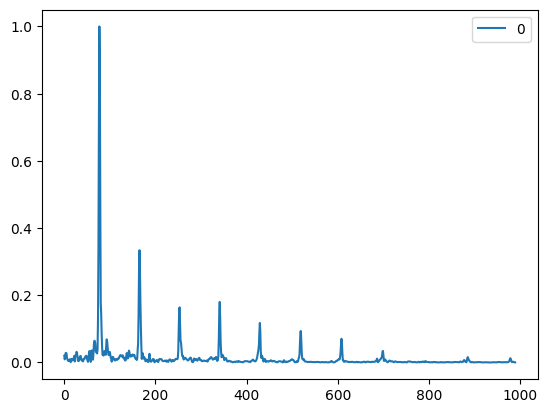

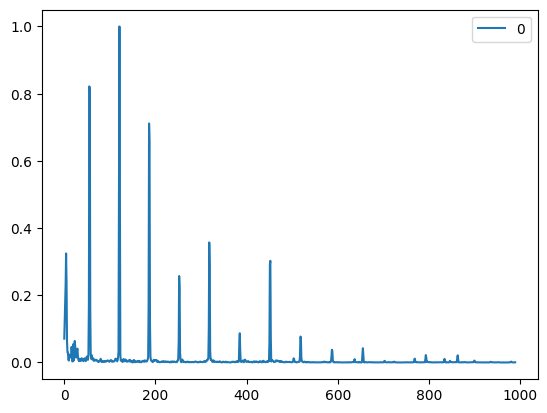

In [57]:
pd.DataFrame(transforms[100]).plot()
pd.DataFrame(transforms[200]).plot()
pd.DataFrame(transforms[300]).plot()
pd.DataFrame(transforms[400]).plot()

This approach should leave you with the appropriate information to start grabbing the base tones from each transform and modifying the result.

Futher work:
 - How exactly do we isolate the different peaks? If we want to simply grab the tallest peak we can just take the maximum value from each transform. To get other peaks, we will need to define "peak" in a way that python understands